In [1]:
import yaml, xarray as xr, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

REG_PATH = "../configs/data_registry.yml"
SCENARIO = "obsclim_histsoc"  # change later for other scenarios
MODELS = ["h08", "hydropy", "jules-w2", "miroc-integ-land", "watergap2-2e", "web-dhm-sg", "lpjml5-7-10-fire"]

with open(REG_PATH, "r") as f:
    REG = yaml.safe_load(f)

# convenience accessor for processed _1m files
def processed_path(model: str, scenario: str) -> str:
    try:
        return REG["processed"]["models_1m"][model][scenario]
    except KeyError as e:
        raise KeyError(f"Missing processed path for {model} / {scenario} in {REG_PATH}") from e

In [2]:
def lat_weights(da: xr.DataArray) -> xr.DataArray:
    # expects a lat coordinate named 'lat' in degrees
    lat = da["lat"]
    w = np.cos(np.deg2rad(lat))
    # normalize to sum to 1 over valid grid points
    w = w / w.where(np.isfinite(w)).sum()
    return w

In [3]:
series = {}  # model -> 12-month climatology (DataArray)

for m in MODELS:
    p = processed_path(m, SCENARIO)
    ds = xr.open_dataset(p)
    da = ds["soilmoist_1m"]

    # Optional period slice:
    da = da.sel(time=slice("1990-01-01", "2019-12-01"))

    # Reduce to a single global mean time series (area-weighted by latitude)
    w = lat_weights(da)
    gm = (da * w).sum("lat", skipna=True).mean("lon", skipna=True)

    # Monthly climatology (12 points)
    clim = gm.groupby("time.month").mean("time", skipna=True)
    clim.name = m
    series[m] = clim

In [4]:
print("Global mean (unclimatized) by model (kg m^-2):")
for m in MODELS:
    p = processed_path(m, SCENARIO)
    ds = xr.open_dataset(p)
    da = ds["soilmoist_1m"]
    w = lat_weights(da)
    gm = (da * w).sum("lat", skipna=True).mean("lon", skipna=True)
    print(f"  {m:16s}: {float(gm.mean('time')):8.3f}")

Global mean (unclimatized) by model (kg m^-2):
  h08             :   25.622
  hydropy         :   74.980
  jules-w2        :   64.000
  miroc-integ-land:   61.924
  watergap2-2e    :   13.718
  web-dhm-sg      :  180.323
  lpjml5-7-10-fire:   63.933


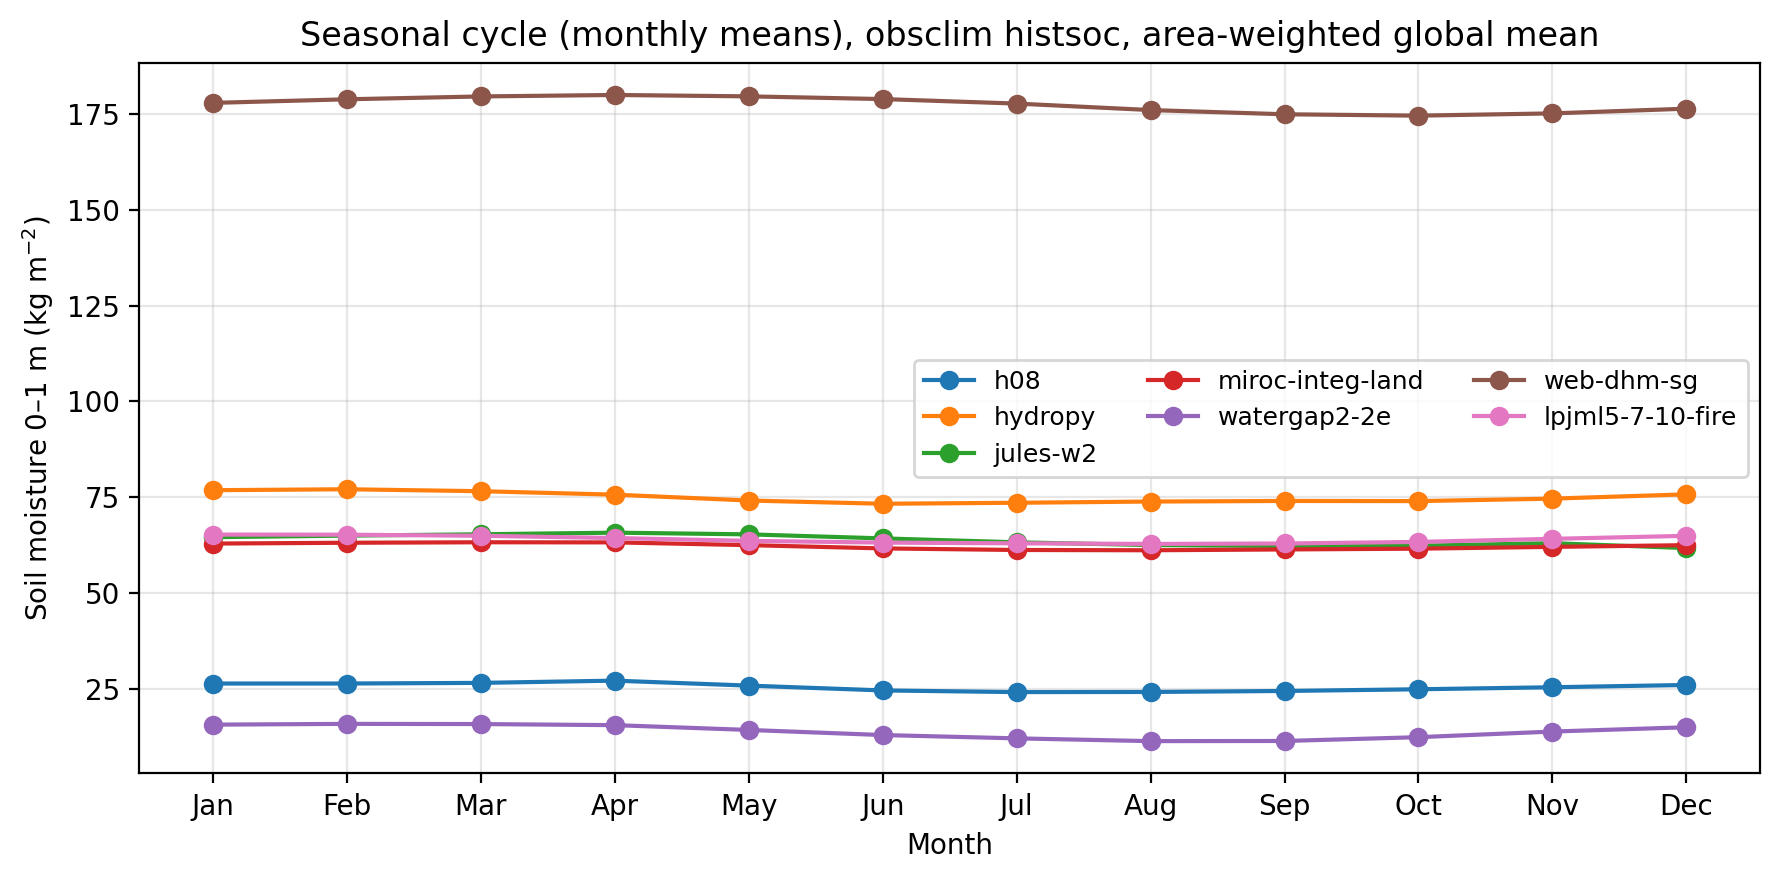

In [12]:
plt.figure(figsize=(9,4.5), dpi=200)
months = np.arange(1,13)
for m, clim in series.items():
    plt.plot(months, clim.values, marker="o", label=m)

plt.xticks(months, ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.xlabel("Month")
plt.ylabel("Soil moisture 0–1 m (kg m$^{-2}$)")
plt.title(f"Seasonal cycle (monthly means), {SCENARIO.replace('_',' ')}, area-weighted global mean")
plt.legend(ncol=3, fontsize=9)
#plt.ylim(60, 67)  # slim y-axis range
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Soil-layer structure and homogenization treatment (v0)

Below is a summary of how each Global Hydrological Model (GHM) was handled during the **v0 homogenization** to the 0–1 m target depth.  
The goal of this version was to reproduce the MATLAB selections faithfully and prepare consistent monthly time series for SSI computation.

- **H08**  
  • Native output variable: `soilmoist` (1 layer).  
  • Climate-zone-specific soil depth (typically < 1 m).  
  • **Action:** used as-is and treated as representing 0–1 m.

- **HydroPy**  
  • Native variable: `rootmoist` (single “bucket” soil layer at field capacity).  
  • Represents plant root-zone storage; exact depth unspecified.  
  • **Action:** kept as root-zone mass, documented that native depth may differ from 1 m.

- **JULES-W2**  
  • 4 layers with thickness = 0.1 m + 0.25 m + 0.65 m + 2 m.  
  • **Action:** summed layers 1–3 (total ≈ 1 m); copied penultimate month if final slice was missing.

- **MIROC-INTEG-LAND**  
  • 13 soil layers extending beyond 1 m.  
  • **Action:** summed layers 1–3 to approximate the 0–1 m storage.

- **LPJmL5-7-10-fire**  
  • 5 hydrologically active soil layers with thicknesses 0.2 m, 0.3 m, 0.5 m, 1.0 m, and 1.0 m.  
  • **Action:** integrated to 0–1 m using `depth_bnds` (equivalent to summing layers 1–3).  
  • This model provides discrete depth bounds, allowing an exact 0–1 m integration.

- **WaterGAP2-2e**  
  • 1 layer with depth 0.1–4 m depending on land use.  
  • **Action:** used single-layer `soilmoist` as-is; noted that effective depth varies spatially (land-use dependent).

- **WEB-DHM-SG**  
  • NetCDF files provide **one aggregated soilmoist layer** (total column) even though the model conceptually has 3 layers (0.05 m + root zone + deep).  
  • **Action:** used the single layer as representing total soil moisture and treated it as 0–1 m equivalent.

**Summary:**  
JULES-W2, MIROC-INTEG-LAND, and LPJmL5-7-10-fire were integrated or summed to represent an exact 0–1 m column.  
H08, HydroPy, WaterGAP2-2e, and WEB-DHM-SG were used directly (root-zone or total-column values), with metadata noting depth assumptions.  
A later v1 homogenization will refine this using true layer bounds and land-use-dependent depths for models where these are variable.